In [1]:
from data_preprocess import *
from train_and_test import *
from config_loader import *
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# 跑通model_v1

In [ ]:
model_name = 'det'
# 参数
model_config = models_config[model_name]
batch_size, lr, optim_name, epochs, metric, alpha = (
    model_config['batch_size'],
    model_config['lr'],
    model_config['optimizer'],
    model_config['epochs'],
    model_config['metric'],
    model_config.get('alpha', None)
)

In [14]:
set_seed(42)

# 数据
batteries_df = read_and_norm(data_path, rated_capacity, failure_threshold)  
train_df, _, test_df, train_loader, _, test_loader = load_data(batteries_df, test_bat, seq_length, batch_size)

In [15]:
# 模型、优化器
model = get_model(model_config, device)
optimizer = get_optimizer(optim_name, model, lr, alpha)
criterion = nn.MSELoss()

# 训练
model_save_path = 'saved_models/demo_{}.pth'.format(model_name)

best_metric = float('inf')
for epoch in range(epochs):
    train_loss = train_epoch(model_config, model, train_loader, device, optimizer, criterion)
    test_loss = test_epoch(model_config, model, test_loader, device, criterion)

    # 在训练集上预测, 并计算评价指标(SP=0)
    sp = 0.0
    train_bats = train_df['battery'].unique()
    train_re_list, train_rmse_list, train_mae_list = [], [], []
    for bat in train_bats:
        bat_df = train_df[train_df['battery'] == bat]
        train_seq = bat_df['capacity'].to_numpy()
        train_pred_seq = predict(model_config, model, sp, train_seq, seq_length, failure_threshold, device)
        train_re, train_rmse, train_mae = cal_metrics(train_seq, train_pred_seq, sp, seq_length, failure_threshold)
        train_re_list.append(train_re)
        train_rmse_list.append(train_rmse)
        train_mae_list.append(train_mae)
    mean_train_re = np.mean(train_re_list)
    mean_train_rmse = np.mean(train_rmse_list)
    mean_train_mae = np.mean(train_mae_list)

    # 在测试集上预测, 并计算评价指标(SP=0)
    test_seq = test_df['capacity'].to_numpy()
    test_pred_seq = predict(model_config, model, sp, test_seq, seq_length, failure_threshold, device)
    test_re, test_rmse, test_mae = cal_metrics(test_seq, test_pred_seq, sp, seq_length, failure_threshold)

    print(
        f"Epoch [{epoch+1}/{epochs}], "
        f"Train Loss: {train_loss:.8f}, Test Loss: {test_loss:.8f}, "
        f"Train RE: {mean_train_re:.3f}, Train RMSE: {mean_train_rmse:.4f}, Train MAE: {mean_train_mae:.4f}, "
        f"Test RE: {test_re:.3f}, Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}"
    )    

    # 保存模型
    metric = mean_train_re
    if metric < best_metric:
        best_metric = metric
        torch.save(model.state_dict(), model_save_path)
        print("New best model saved ...")

Epoch [1/200], Train Loss: 0.02736456, Test Loss: 0.00161663, Train RE: 1.000, Train RMSE: 0.1299, Train MAE: 0.1165, Test RE: 1.000, Test RMSE: 0.1311, Test MAE: 0.1182
New best model saved ...
Epoch [2/200], Train Loss: 0.00089209, Test Loss: 0.00100330, Train RE: 0.527, Train RMSE: 0.3738, Train MAE: 0.3075, Test RE: 0.540, Test RMSE: 0.3816, Test MAE: 0.3100
New best model saved ...
Epoch [3/200], Train Loss: 0.00103990, Test Loss: 0.00092341, Train RE: 1.000, Train RMSE: 0.0756, Train MAE: 0.0589, Test RE: 1.000, Test RMSE: 0.0754, Test MAE: 0.0607
Epoch [4/200], Train Loss: 0.00094118, Test Loss: 0.00087344, Train RE: 1.000, Train RMSE: 0.0936, Train MAE: 0.0783, Test RE: 1.000, Test RMSE: 0.0936, Test MAE: 0.0795
Epoch [5/200], Train Loss: 0.00082645, Test Loss: 0.00223626, Train RE: 0.706, Train RMSE: 0.5767, Train MAE: 0.5163, Test RE: 0.707, Test RMSE: 0.5806, Test MAE: 0.5185
Epoch [6/200], Train Loss: 0.00080924, Test Loss: 0.00099190, Train RE: 0.570, Train RMSE: 0.4502, T

Test RE: 0.008, Test RMSE: 0.0321, Test MAE: 0.0272


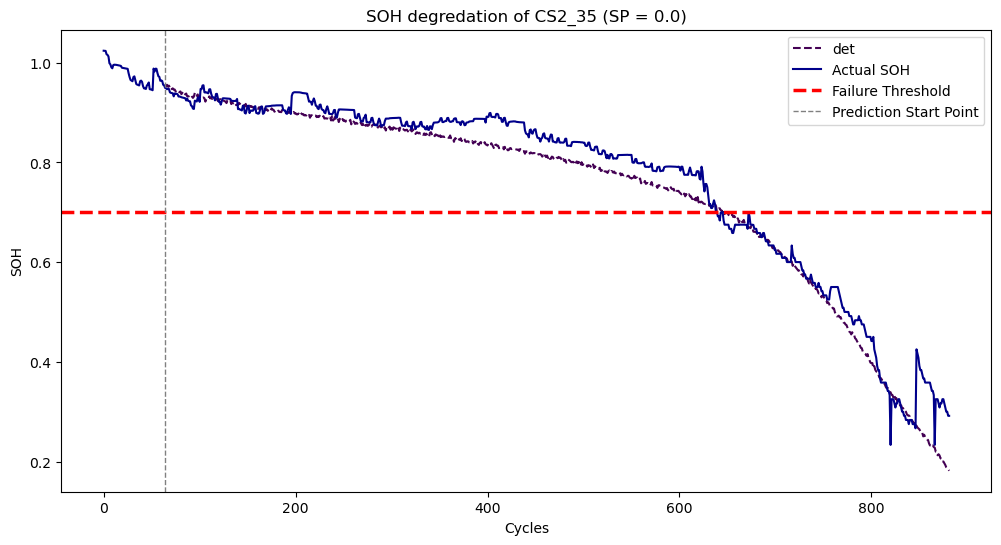

In [16]:
# 测试 (一个模型)
sp = 0.0
pic_save_path = f'pics/{model_name}.png'
test_seq = test_df['capacity'].to_numpy()

# 加载模型
model_config = models_config[model_name]
model = get_model(model_config, device)
model.load_state_dict(torch.load(model_save_path, map_location=device))

# 预测
pred_seq = predict(model_config, model, sp, test_seq, seq_length, failure_threshold, device)
re, rmse, mae = cal_metrics(test_seq, pred_seq, sp, seq_length, failure_threshold)
print(f"Test RE: {re:.3f}, Test RMSE: {rmse:.4f}, Test MAE: {mae:.4f}")

# plot
pred_seqs = {model_name: pred_seq}
plt = plot(test_seq, pred_seqs, sp, failure_threshold, seq_length, test_bat)
plt.savefig(pic_save_path)

# 一次训练多个模型

In [2]:
from data_preprocess import *
from train_and_test import *
from config_loader import *
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [4]:
set_seed(42)

model_names = ['lstm','gru', 'det', 'model_v1']
for model_name in model_names:
    # 参数
    model_config = models_config[model_name]
    batch_size, lr, optim_name, epochs, metric, alpha = (
        model_config['batch_size'],
        model_config['lr'],
        model_config['optimizer'],
        model_config['epochs'],
        model_config['metric'],
        model_config.get('alpha', None)
    )

    # 数据
    batteries_df = read_and_norm(data_path, rated_capacity, failure_threshold)  
    train_df, _, test_df, train_loader, _, test_loader = load_data(batteries_df, test_bat, seq_length, batch_size)

    # 模型、优化器
    model = get_model(model_config, device, seq_length)
    optimizer = get_optimizer(optim_name, model, lr, alpha)
    criterion = nn.MSELoss()

    # 训练
    model_save_path = f'saved_models/{DATASET}/{model_name}.pth'

    best_metric = float('inf')
    for epoch in range(epochs):
        train_loss = train_epoch(model_config, model, train_loader, device, optimizer, criterion)
        test_loss = test_epoch(model_config, model, test_loader, device, criterion)

        # 在训练集上预测, 并计算评价指标(SP=0)
        sp = 0.0
        train_bats = train_df['battery'].unique()
        train_re_list, train_rmse_list, train_mae_list = [], [], []
        for bat in train_bats:
            bat_df = train_df[train_df['battery'] == bat]
            train_seq = bat_df['capacity'].to_numpy()
            train_pred_seq = predict(model_config, model, sp, train_seq, seq_length, failure_threshold, device)
            train_re, train_rmse, train_mae = cal_metrics(train_seq, train_pred_seq, sp, seq_length, failure_threshold)
            train_re_list.append(train_re)
            train_rmse_list.append(train_rmse)
            train_mae_list.append(train_mae)
        mean_train_re = np.mean(train_re_list)
        mean_train_rmse = np.mean(train_rmse_list)
        mean_train_mae = np.mean(train_mae_list)

        # 在测试集上预测, 并计算评价指标(SP=0)
        test_seq = test_df['capacity'].to_numpy()
        test_pred_seq = predict(model_config, model, sp, test_seq, seq_length, failure_threshold, device)
        test_re, test_rmse, test_mae = cal_metrics(test_seq, test_pred_seq, sp, seq_length, failure_threshold)

        print(
            f"Model: {model_name}, Epoch [{epoch+1}/{epochs}] | "
            f"Train Loss: {train_loss:.8f}, Test Loss: {test_loss:.8f} | "
            f"Train RE: {mean_train_re:.3f}, Train RMSE: {mean_train_rmse:.4f}, Train MAE: {mean_train_mae:.4f} | "
            f"Test RE: {test_re:.3f}, Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}"
        )    

        # 保存模型
        metric = mean_train_re
        if metric < best_metric:
            best_metric = metric
            torch.save(model.state_dict(), model_save_path)
            print("New best model saved ...")

Model: lstm, Epoch [1/200] | Train Loss: 0.08200943, Test Loss: 0.01511018 | Train RE: 1.000, Train RMSE: 0.0987, Train MAE: 0.0832 | Test RE: 1.000, Test RMSE: 0.0934, Test MAE: 0.0755
New best model saved ...
Model: lstm, Epoch [2/200] | Train Loss: 0.01131318, Test Loss: 0.01184075 | Train RE: 1.000, Train RMSE: 0.0895, Train MAE: 0.0760 | Test RE: 1.000, Test RMSE: 0.0848, Test MAE: 0.0707
Model: lstm, Epoch [3/200] | Train Loss: 0.00884254, Test Loss: 0.00570747 | Train RE: 1.000, Train RMSE: 0.0700, Train MAE: 0.0614 | Test RE: 1.000, Test RMSE: 0.0700, Test MAE: 0.0624
Model: lstm, Epoch [4/200] | Train Loss: 0.00798947, Test Loss: 0.00348631 | Train RE: 1.000, Train RMSE: 0.0830, Train MAE: 0.0675 | Test RE: 1.000, Test RMSE: 0.0884, Test MAE: 0.0730
Model: lstm, Epoch [5/200] | Train Loss: 0.00786850, Test Loss: 0.00698356 | Train RE: 1.000, Train RMSE: 0.1021, Train MAE: 0.0850 | Test RE: 1.000, Test RMSE: 0.0970, Test MAE: 0.0768
Model: lstm, Epoch [6/200] | Train Loss: 0.00

## 输出结果（表格、曲线）

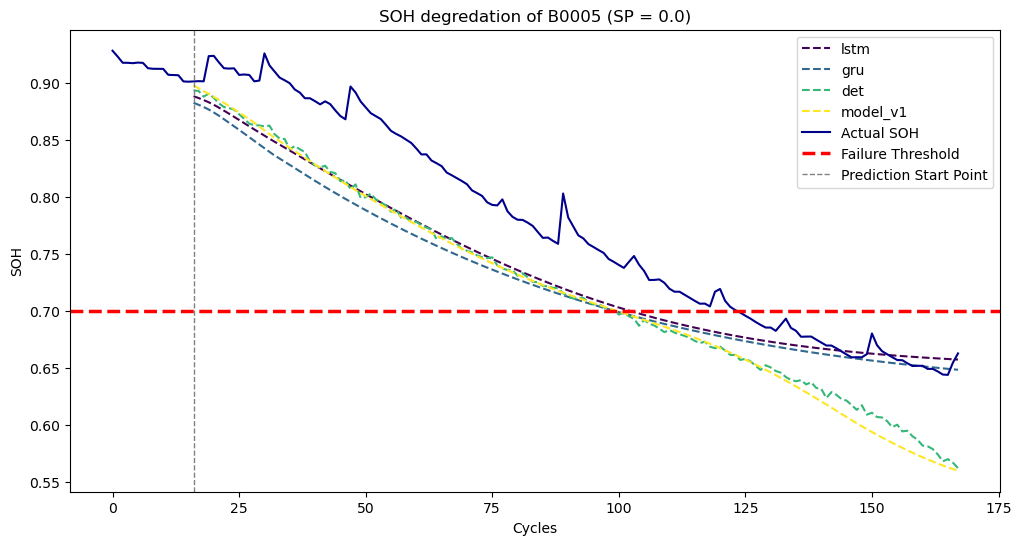

,model,re,rmse,mae
0,lstm,0.168,0.0509,0.0484
1,gru,0.192,0.0601,0.0569
2,det,0.208,0.0526,0.0506
3,model_v1,0.192,0.0531,0.0507


In [6]:
sp = 0.0
pic_save_path = f'pics/{DATASET}/all_models.png'
test_seq = test_df['capacity'].to_numpy()
result = []
pred_seqs = {}

model_names = ['lstm', 'gru', 'det', 'model_v1']
for model_name in model_names:
    model_save_path = f'saved_models/{DATASET}/{model_name}.pth'

    # 加载模型
    model_config = models_config[model_name]
    model = get_model(model_config, device, seq_length)
    model.load_state_dict(torch.load(model_save_path, map_location=device))

    # 预测
    pred_seq = predict(model_config, model, sp, test_seq, seq_length, failure_threshold, device)
    re, rmse, mae = cal_metrics(test_seq, pred_seq, sp, seq_length, failure_threshold)

    result.append({
        'model': model_name,
        're': round(re, 3),
        'rmse': round(rmse, 4),
        'mae': round(mae, 4)
    })
    pred_seqs[model_name] = pred_seq

plt = plot(test_seq, pred_seqs, sp, failure_threshold, seq_length, test_bat)
plt.savefig(pic_save_path)
plt.show()
result_df = pd.DataFrame(result)
result_df